In [12]:
# importing libraries that will be required later
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk

In [13]:
# nltk.download_shell()

# creating the messages dataset

In [14]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

In [15]:
# just checking what it looks like
for msg_no, msg in enumerate(messages[:10]):
    print(msg_no, msg)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

# Creating messages dataframe

In [16]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', names=['label', 'message'])

In [17]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [18]:
messages['length'] = messages['message'].apply(len)

In [19]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [20]:
messages.describe()

,length
count,5572.000000
mean,80.489950
std,59.942907
min,2.000000
25%,36.000000
50%,62.000000
75%,122.000000
max,910.000000


# Rationalizing the data

In [21]:
messages[messages['length'] == 910]

,label,message,length
1085,ham,For me the love should start with attraction.i...,910


array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

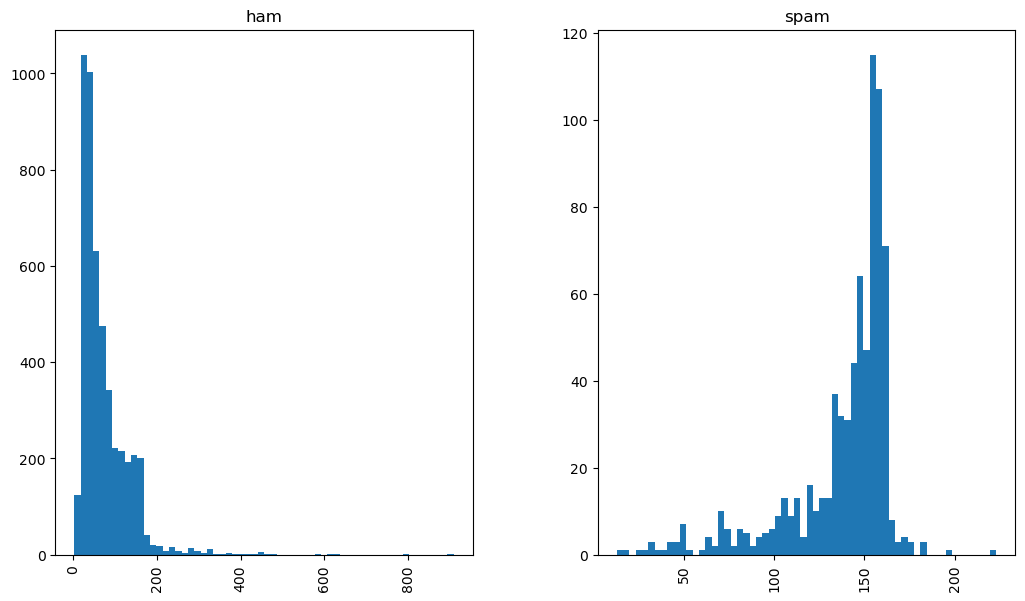

In [22]:
messages.hist(column='length', by='label', bins =60, figsize=(12,7))

From above histograms, it can be seen that spams have more words.

Getting the model to clean the messages, to be able to read them properly.

In [23]:

from nltk.corpus import stopwords
import string

In [24]:
def process_text(msg):
    nopunc = [char for char in msg if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [25]:
messages['message'].head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [26]:
messages['message'].head(5).apply(process_text)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

### Vectorizing the words in the dataframe messages

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
bow_transform = CountVectorizer(analyzer=process_text).fit(messages['message'])

In [29]:
msg_bow = bow_transform.transform(messages['message'])

In [30]:
msg_bow.nnz

50548

### Transforming messages dataframe using Term Frequency-Inverse Document Frequency module

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer

In [32]:
tfidf_transformer = TfidfTransformer().fit(msg_bow)

In [36]:
msg_tfidf = tfidf_transformer.transform(msg_bow)

In [37]:
sparsity = (100.0 * msg_bow.nnz / (msg_bow.shape[0] * msg_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.07940295412668218


### Classifying the transformed data using MultiNominalNB 

In [38]:
from sklearn.naive_bayes import MultinomialNB

In [40]:
spam_detect_model = MultinomialNB().fit(msg_tfidf, messages['label'])

In [41]:
pred = spam_detect_model.predict(msg_tfidf)

In [42]:
pred

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype='<U4')

### Training and testing the data to be able to make predictions later.

In [43]:
from sklearn.model_selection import train_test_split

In [46]:
msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'],
                                                               test_size=0.3, random_state=101)

### Using Pipeline to avoid repitition of steps

In [47]:
from sklearn.pipeline import Pipeline

In [52]:
pipeline = Pipeline(
[
    ('bow', CountVectorizer(analyzer=process_text)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [53]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process_text at 0x00000276C39E2E50>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [55]:
predictions = pipeline.predict(msg_test)

### Checking the accuracy of our predictions

In [56]:
from sklearn.metrics import classification_report

In [57]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1475
        spam       1.00      0.65      0.79       197

    accuracy                           0.96      1672
   macro avg       0.98      0.83      0.88      1672
weighted avg       0.96      0.96      0.96      1672



### The spam detector model is ready!